In [45]:
'''This is particularly useful during development when you are making changes to modules and want those changes to be reflected immediately without restarting the kernel or re-importing the module manually.
'''
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

DATA_SOURCE = os.environ.get("DATA_SOURCE")

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import(
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    losses
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Parameters

CHANNELS = 1 
IMAGE_SIZE = 64
EPOCHS = 300
BATCH_SIZE = 128
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1 #specific to GANs
Z_DIM = 100


In [73]:
def display_images(image_set):
    num_rows = 2
    num_cols = 10
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4))

    axes = axes.flatten()

    for i, image_batch in enumerate(image_set.take(1)): # get the first batch
        for j, image in enumerate(image_batch[:num_rows*num_cols]): 
            ax = axes[i * num_cols + j]
            ax.imshow(image.numpy().squeeze(), cmap='gray')
            ax.set_title(image.shape)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Found 40000 files belonging to 1 classes.


2024-04-18 09:20:39.376030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:85: Filling up shuffle buffer (this may take a while): 810 of 1024
2024-04-18 09:20:41.977960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


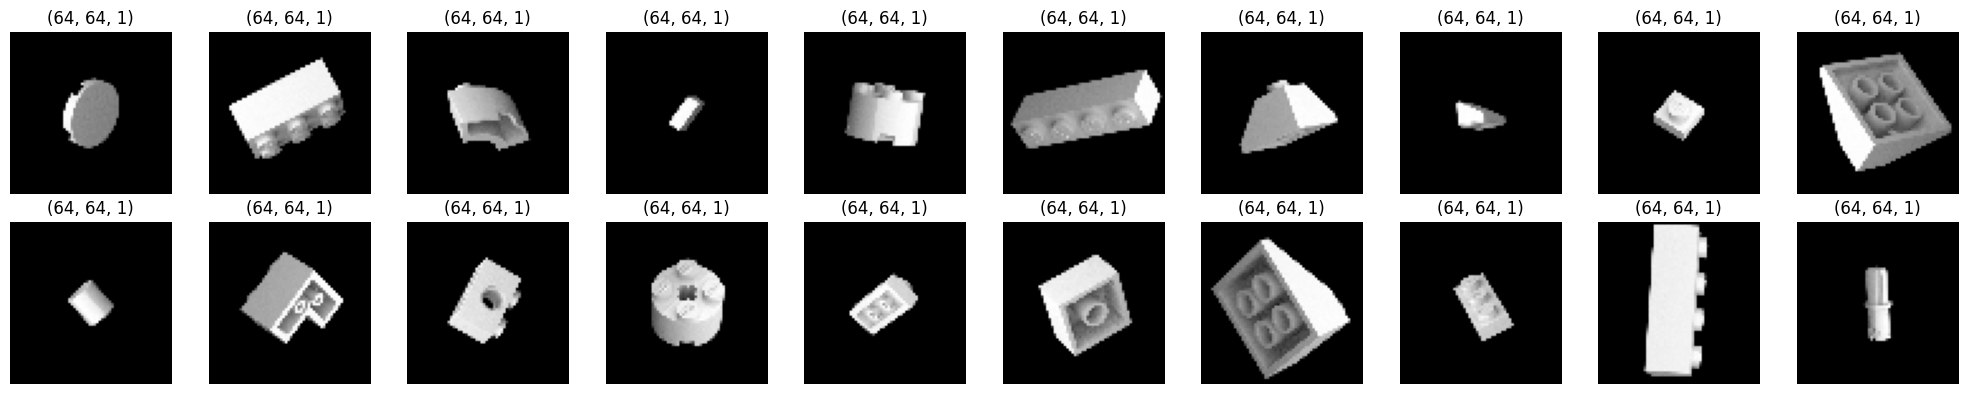

In [75]:
train_data = utils.image_dataset_from_directory(
    DATA_SOURCE + "/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

display_images(train_data)

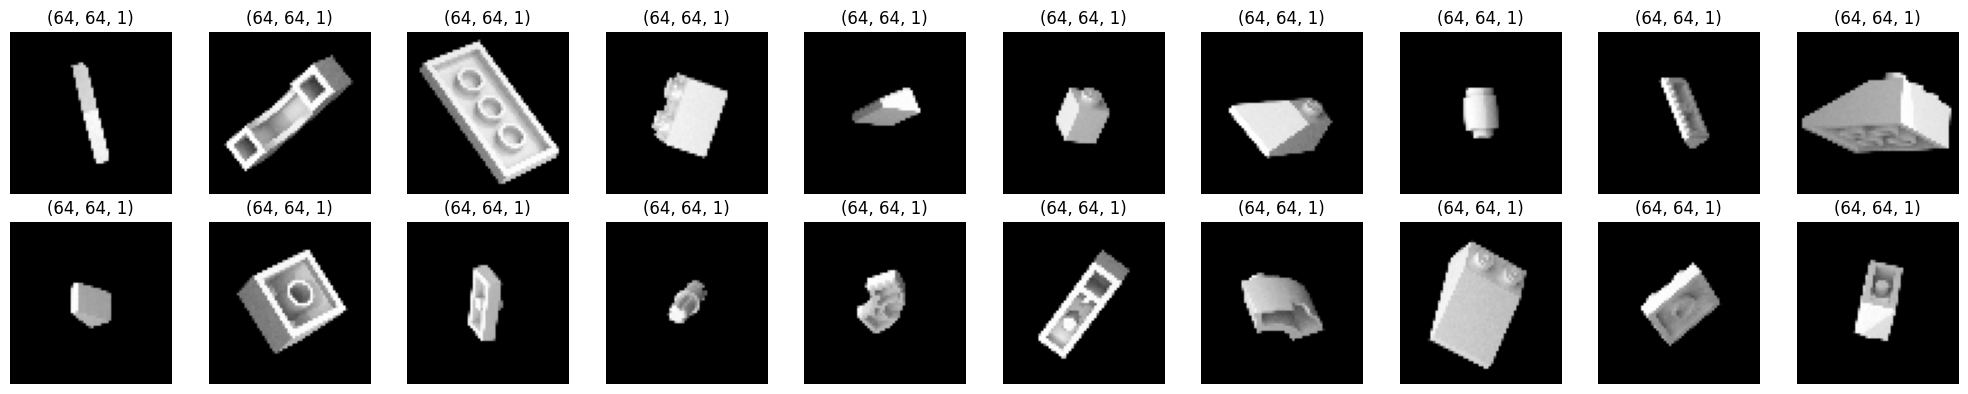

In [76]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

train = train_data.map(lambda x: preprocess(x))

display_images(train)

Why tanh?

In simple terms, when training GANs we use a tanh activiation because it provides for stronger gradients than the sigmoid. This is because the 
sigmoid has a much smaller window along the y axis--between 0 and 1--where gradients increase or decrease. At the edges the gradients become very small. Tanh on the other hand goes from -1 to 1.

From ChatGPT

Both tanh and sigmoid activation functions are commonly used in GANs (Generative Adversarial Networks), but they serve slightly different purposes.

Tanh Activation Function:

The tanh function squashes the input values to the range [-1, 1].
It provides stronger gradients for inputs in the saturated regions compared to the sigmoid function, which helps in faster convergence during training.
Using tanh can help in centering the outputs around zero, which may be desirable in certain contexts, especially when working with image data with pixel values ranging from 0 to 255.
Sigmoid Activation Function:

Sigmoid Activation Function:

The sigmoid function squashes the input values to the range [0, 1].
It is commonly used in the output layer of the generator in GANs to produce outputs that resemble probabilities.
Sigmoid is particularly useful when the output needs to be interpreted as a probability, such as in binary classification tasks or when generating images with pixel values normalized to the range [0, 1].
In summary, tanh is often used in the hidden layers of both the generator and discriminator to provide stronger gradients and help with convergence, while sigmoid is commonly used in the output layer of the generator to produce outputs that resemble probabilities. However, the choice between tanh and sigmoid depends on the specific requirements of the GAN architecture and the nature of the data being generated.

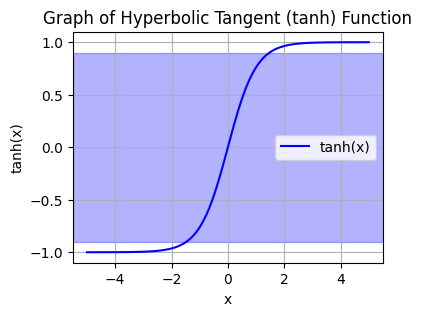

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from -5 to 5
x = np.linspace(-5, 5, 100)

# Compute tanh(x) for each x
y = np.tanh(x)

# Plot the tanh function
plt.figure(figsize=(4, 3))
plt.plot(x, y, label='tanh(x)', color='b')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('Graph of Hyperbolic Tangent (tanh) Function')
plt.grid(True)
plt.legend()
plt.axhspan(-0.90, 0.90, color='blue', alpha=0.3)
plt.show()

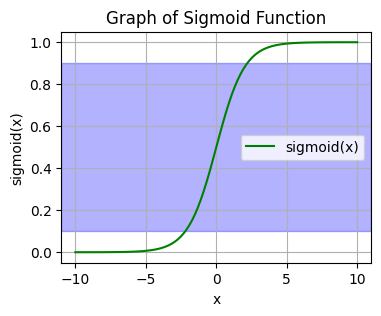

In [50]:
# Generate x values from -5 to 5
x = np.linspace(-10, 10, 100)

# Compute tanh(x) for each x
y = 1 / (1 + np.exp(-x))

plt.figure(figsize=(4, 3))
plt.plot(x, y, label='sigmoid(x)', color='g')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.title('Graph of Sigmoid Function')
plt.grid(True)
plt.legend()
plt.axhspan(0.1, 0.9, color='blue', alpha=0.3)
plt.show()

In [78]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_12 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_21 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                           

In [98]:
# Generator

generator_input = layers.Input(shape=(Z_DIM,), name="generator_input")
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

assert x.shape == (None, 4, 4, 512), f"Expected (None, 4, 4, 512) but got tensor shape f{x.shape}"

x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

assert x.shape == (None, 8, 8, 256), f"Expected (None, 8, 8, 256) but got tensor shape f{x.shape}"

x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

assert x.shape == (None, 16, 16, 128), f"Expected (None, 16, 16, 128) but got tensor shape f{x.shape}"

x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

assert x.shape == (None, 32, 32, 64), f"Expected (None, 32, 32, 64) but got tensor shape {x.shape}"

generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh"
)(x)

generator = models.Model(generator_input, generator_output)
generator.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), name='conv2d_transpose_40/Tanh:0', description="created by layer 'conv2d_transpose_40'")
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLaye  [(None, 100)]             0         
 r)                                                              
                                                                 
 reshape_9 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_36 (Conv2  (None, 4, 4, 512)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_48 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
              

In [91]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):

        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
 
        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            print("generated_images", generated_images)
            real_predictions = self.discriminator(real_images, training=True)

            fake_predictions = self.discriminator(
                generated_images, training=True
            )
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}
    
    # Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.999
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.999
    ),
)

In [81]:
if LOAD_MODEL:
    dcgan.load_weights("/dcgan/checkpoint/checkpoint.ckpt")

In [82]:
# Create callback

model_checkpoint_callback = callbacks.ModelCheckpoint(
    "./dcgan/checkpoint/checkpoint",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0
)

tensorboard_callback = callbacks.TensorBoard("./dcgan/logs")

In [83]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()

    def display_images(self):

        fig, axes = plt.subplots(2, 10, figsize=(20, 4))
        axes = axes.flatten()

        for i, img in enumerate(self.generated_images):
            ax = axes[i]
            ax.imshow(img)
            ax.axes('off')
            ax.set_title(f'Image {i + 1}')

In [92]:
# Train
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM)
    ]
)

generator.save("./dcgan/models/generator")
discriminator.save("./dcgan/models/discriminator")

Epoch 1/300
generated_images Tensor("model_7/conv2d_transpose_15/Tanh:0", shape=(None, 16, 16, 1), dtype=float32)


ValueError: in user code:

    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/var/folders/pc/2lgq2g5d7cg8jb8vf9kkmrcc0000gn/T/ipykernel_84034/496642168.py", line 48, in train_step
        fake_predictions = self.discriminator(
    File "/usr/local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_6" is incompatible with the layer: expected shape=(None, 64, 64, 1), found shape=(None, 16, 16, 1)
